In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def get_flow(path, src_ip, dst_ip):
    data = pd.read_csv(path)
    raw_data = data.values

    clean_data = []
    flows = []

    # 패킷의 전송 간격을 구함
    interval = []
    last = 0
    for line in raw_data:
        if line[2] == src_ip and line[3] == dst_ip:
            interval.append(line[1]-last)
            last = line[1]
            clean_data.append(line)

    # 패킷 평균 전송 간격
    avg = sum(interval) / len(interval)

    diverge = []

    i = 0
    # 평균 전송간격보다 큰 경우 flow를 분리를 위한 인덱스 찾기
    for t in interval:
        if t >= avg:
            diverge.append(i)
        i = i + 1

    # 찾은 인덱스로 flow를 분리
    prefix = 0
    for idx in diverge:
        if idx >= len(clean_data):
            break
        flow = clean_data[prefix:idx]
        flows.append(flow)
        prefix = idx + 1

    if len(flows) < 100:
        return 0
    print("## 총 ", len(flows), "개의 flow 발견")

    # 평균 인터벌
    avg_ivl = []
    # 평균 페이로드 크기
    avg_pay = []
    # 평균 패킷 수
    avg_cnt = []
    # 프로토콜 넘뻐
    pcl = []

    for flow in flows:
        last = 0
        ivl = 0
        payload = 0
        if len(flow) <= 0:
            continue
        for line in flow:
            ivl = ivl + (line[1]-last)
            last = line[1]
            payload = payload + line[5]

        # 값 입력
        avg_ivl.append(ivl / len(flow))
        avg_pay.append(payload / len(flow))
        avg_cnt.append(len(flow))
        pcl.append(flow[0][4])

    return [avg_ivl, avg_cnt, avg_pay, pcl]


In [ ]:
# for preprocessing only
def data_process(path):
    nm = path.split('/')[3]
    print(nm)
    data = pd.read_csv(path)
    src_set = set(data["ip.src"])
    
    rl = np.array([])
    
    for ips in src_set:
        if type(ips) == float:
            continue
        dst_set = set(data[data["ip.src"] == ips]["ip.dst"])
        for ipd in dst_set:
            tmp = get_flow(path, ips, ipd)
            if tmp != 0:
                tmp = np.array(tmp)
                if len(rl) == 0:
                    rl = tmp
                else:
                    rl = np.hstack((rl, tmp))
    rl = pd.DataFrame(rl.transpose(), columns=['ivl', 'cnt', 'pay', 'pcl'])
    print(rl)
    rl.to_csv("./processed/VPN/" + nm + "_processed.csv", index=False)

In [ ]:
data_process("./Datasets/VPN/Chat/merge.csv")
data_process("./Datasets/VPN/Email/merge.csv")
data_process("./Datasets/VPN/FileTransfer/merge.csv")
data_process("./Datasets/VPN/P2P/merge.csv")
data_process("./Datasets/VPN/Streaming/merge.csv")
data_process("./Datasets/VPN/VoIP/merge.csv")

In [2]:
"""
# for origin data only
low_flow = get_flow("./30sec_server.csv", '10.0.0.1', '10.0.0.2')
high_flow = get_flow("./Datasets/nonVPN/Chat/merge.csv", '131.202.240.87', '10.0.0.2')
chat_flow = get_flow("./chat_server.csv", '10.0.0.1', '10.0.0.2')
"""
target_nm = 5
class_nm = ['Chat', 'Email', 'FileTransfer', 'P2P', 'Streaming', 'VoIP']
oposit_data = []
for i in range(len(class_nm)):
    if i == target_nm:
        target_data = pd.read_csv("./processed/" + class_nm[i] + "_processed.csv").values
        print(target_data)
    else:
        oposit_data.extend(pd.read_csv("./processed/" + class_nm[i] + "_processed.csv").values)

print(len(target_data))
print(len(oposit_data))


[[7.70450000e-03 2.00000000e+00 1.25000000e+02 1.70000000e+01]
 [5.54610000e-02 1.00000000e+00 1.25000000e+02 1.70000000e+01]
 [9.72090000e-02 1.00000000e+00 1.25000000e+02 1.70000000e+01]
 ...
 [3.41694829e+03 1.00000000e+00 6.00000000e+01 1.70000000e+01]
 [3.42698774e+03 1.00000000e+00 6.00000000e+01 1.70000000e+01]
 [3.43702779e+03 1.00000000e+00 6.00000000e+01 1.70000000e+01]]
450285
102720


In [3]:
print(target_data[:10000])
print(oposit_data[:10000])

[[  0.298518     1.         131.          17.        ]
 [  1.92357      1.         131.          17.        ]
 [  2.463493     2.          92.          17.        ]
 ...
 [ 82.88206786   7.          64.          17.        ]
 [195.98284867   3.          64.          17.        ]
 [198.16387533   3.          64.          17.        ]]
[array([91.66324,  1.     , 64.     , 17.     ]), array([92.075626,  1.      , 64.      , 17.      ]), array([92.561754,  1.      , 64.      , 17.      ]), array([31.003565,  3.      , 64.      , 17.      ]), array([93.423402,  1.      , 64.      , 17.      ]), array([94.43086,  1.     , 64.     , 17.     ]), array([31.65393,  3.     , 64.     , 17.     ]), array([95.373815,  1.      , 64.      , 17.      ]), array([95.800285,  1.      , 64.      , 17.      ]), array([96.210716,  1.      , 64.      , 17.      ]), array([97.153085,  1.      , 64.      , 17.      ]), array([32.52141667,  3.        , 64.        , 17.        ]), array([97.974533,  1.      , 64

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler()
scaler.fit(target_data)
target_data = scaler.transform(target_data)

In [5]:
scaler.fit(oposit_data)
oposit_data = scaler.transform(oposit_data)

In [6]:
target_data = pd.DataFrame({'interval': target_data[:, 0], 'count': target_data[:, 1], 'size': target_data[:, 2], 'proto': target_data[:, 3], 'label': 0})
oposit_data = pd.DataFrame({'interval': oposit_data[:, 0], 'count': oposit_data[:, 1], 'size': oposit_data[:, 2], 'proto': oposit_data[:, 3], 'label': 1})

In [7]:
full_data = pd.concat([target_data, oposit_data])

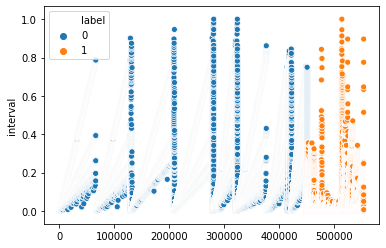

In [8]:
sns.scatterplot(x=range(len(full_data['interval'])), y=full_data['interval'], hue=full_data['label'])

In [10]:
from sklearn.cluster import KMeans, DBSCAN

In [11]:
X = full_data.drop(['label'], axis=1)
Y = full_data['label']

In [12]:
kmeans = KMeans(n_clusters=2).fit(X.values)
X['cid'] = kmeans.labels_

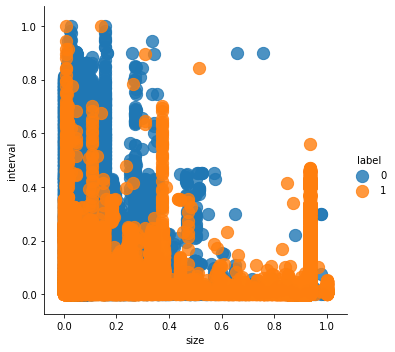

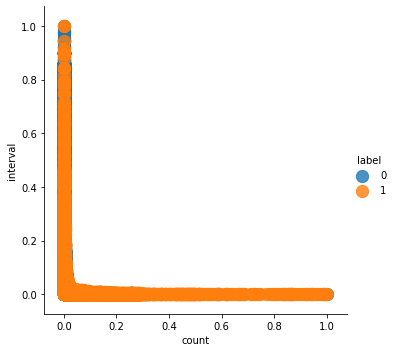

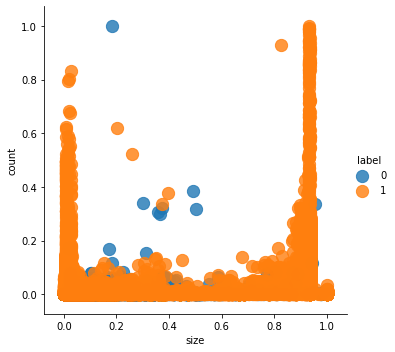

In [13]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

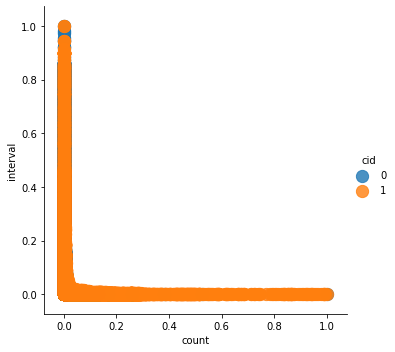

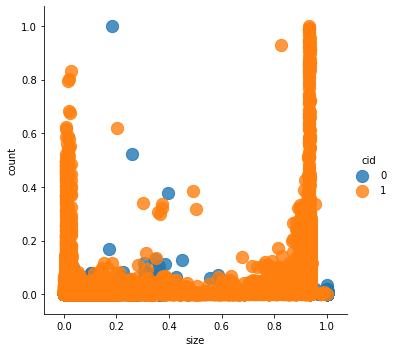

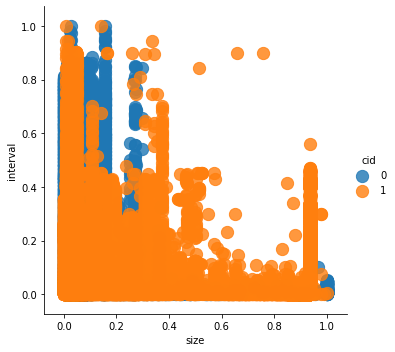

In [14]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':150}, hue='cid')

In [15]:
y_pred = list(kmeans.labels_)
scoreY = list(Y)
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print(hit/len(scoreY))

0.9775625898500013


In [16]:
X = X.drop(['cid'], axis=1)

In [ ]:
dbscan = DBSCAN(eps=1, min_samples=3000).fit(X)

In [ ]:
y_pred = dbscan.fit_predict(X)
X['cid'] = y_pred

In [ ]:
sns.lmplot('size', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('count', 'interval', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')
sns.lmplot('size', 'count', data=full_data, fit_reg=False, scatter_kws={'s':150}, hue='label')

In [ ]:
sns.lmplot('count', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'count', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')
sns.lmplot('size', 'interval', data=X, fit_reg=False, scatter_kws={'s':50}, hue='cid')

In [ ]:
hit = 0
for i in range(0, len(y_pred)):
    if (y_pred[i] + scoreY[i]) == 0:
        hit = hit + 1
print(hit/len(scoreY))

In [10]:
import tensorflow as tf
import time
from dagmm import DAGMM

In [11]:
full_data = pd.concat([target_data, oposit_data])
X = full_data.drop(['label'], axis=1)

In [18]:
tf.reset_default_graph()

In [19]:
model_dagmm = DAGMM(
    comp_hiddens=[16, 8,1], comp_activation=tf.nn.tanh,
    est_hiddens=[8,4], est_activation=tf.nn.tanh, est_dropout_ratio=0.25,
    epoch_size=200, minibatch_size=100
)

In [20]:
start = time.time()
model_dagmm.fit(X)
end = time.time()
print("Learning time = ", end-start)

 epoch 100/200 : loss = 0.306
 epoch 200/200 : loss = 0.159
Learning time =  6141.470624446869


In [21]:
full_data = pd.concat([target_data, oposit_data])
X = full_data.drop(['label'], axis=1)
Y = full_data['label']

In [22]:
energy = model_dagmm.predict(X)

Text(0, 0.5, 'Number of Sample(s)')

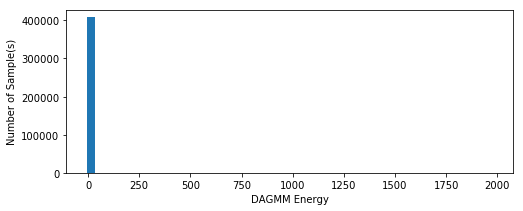

In [23]:
plt.figure(figsize=[8,3])
histinfo = plt.hist(energy, bins=50)
plt.xlabel("DAGMM Energy")
plt.ylabel("Number of Sample(s)")

In [24]:
energy.sort()
threshold = len(energy)*0.9
print(threshold)
threshold = energy[-int(threshold)]
print(threshold)
cid = []
for node in energy:
    if node > threshold:
        cid.append(1)
    else:
        cid.append(0)

366777.9
-6.5700727


In [25]:
X['cid'] = cid
X['energy'] = energy
X['label'] = Y

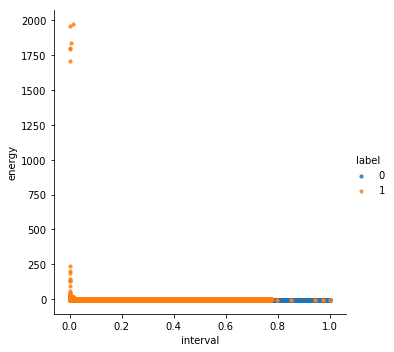

In [26]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':10}, hue='label')

In [29]:
y_pred = list(X['cid'])
scoreY = list(X['label'])
hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i] and scoreY[i] == 1:
        hit = hit + 1
print("PP", hit/len([x for x in scoreY if x == 1]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i] and scoreY[i] == 0:
        hit = hit + 1
print("FF", hit/len([x for x in scoreY if x == 0]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] != scoreY[i] and scoreY[i] == 0:
        hit = hit + 1
print("PF", hit/len([x for x in scoreY if x == 0]))

hit = 0
for i in range(0, len(y_pred)):
    if y_pred[i] != scoreY[i] and scoreY[i] == 1:
        hit = hit + 1
print("FP", hit/len([x for x in scoreY if x == 1]))

for i in range(0, len(y_pred)):
    if y_pred[i] == scoreY[i]:
        hit = hit + 1
print("Accuracy", hit/len(scoreY))

PP 1.0
FF 0.15779569996554088
PF 0.8422043000344591
FP 0.0
Accuracy 0.4662442857107803


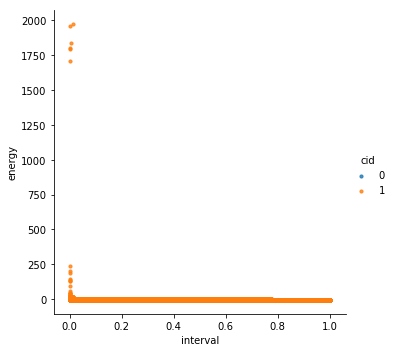

In [28]:
sns.lmplot('interval', 'energy', data=X, fit_reg=False, scatter_kws={'s':10}, hue='cid')